# Emotion Classification

### Imports

In [3]:
# required imports
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import tensorflow as tf
import util
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

### Data Pre processing

In [4]:
# Define the path to the directory containing training images
train_dir = 'images/train'

# Define the path to the directory containing validation images
validation_dir = 'images/validation'

# Define the path to the directory containing testing images
test_dir = 'images/validation'

In [6]:
# exploring training dataset 
print("Angry:", len(glob.glob(train_dir+'/angry/*')))
print("Happy:", len(glob.glob(train_dir+'/happy/*')))
print("Sad:", len(glob.glob(train_dir+'/sad/*')))
print("Surprise:", len(glob.glob(train_dir+'/surprise/*')))

Angry: 3993
Happy: 7164
Sad: 4938
Surprise: 3205


In [7]:
# Set the image size to the size of the try_img object
try_img = PIL.Image.open(train_dir+'/angry/0.jpg')
IMAGE_SIZE = try_img._size

# Set the batch size to 32
BATCH_SIZE = 32

# Create an ImageDataGenerator object for the training data with data augmentation techniques
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,   # rotate images randomly by up to 10 degrees
                                    zoom_range = 0.1,    # zoom in/out randomly by up to 10%
                                  )

# Use the ImageDataGenerator to generate batches of training data from the train_dir directory
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Path to the directory containing the training images
    target_size = IMAGE_SIZE,  # Resize images to the specified size
    batch_size = BATCH_SIZE,   # Set the batch size to 32
    class_mode ='categorical'  # Use categorical classification (more than 2 classes)
)

# Create an ImageDataGenerator object for the validation data with no data augmentation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Use the ImageDataGenerator to generate batches of validation data from the validation_dir directory
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,            # Path to the directory containing the validation images
    target_size = IMAGE_SIZE,  # Resize images to the specified size
    batch_size = BATCH_SIZE,   # Set the batch size to 32
    class_mode='categorical'   # Use categorical classification (more than 2 classes)
)

# Create an ImageDataGenerator object for the test data with no data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Use the ImageDataGenerator to generate batches of test data from the test_dir directory
test_generator = test_datagen.flow_from_directory(
    test_dir,                  # Path to the directory containing the test images
    target_size = IMAGE_SIZE,  # Resize images to the specified size
    batch_size = 8,            # Set the batch size to 8
    class_mode = 'categorical' # Use categorical classification (more than 2 classes)
)


Found 19300 images belonging to 4 classes.
Found 4721 images belonging to 4 classes.
Found 4721 images belonging to 4 classes.


### Face detection

In [8]:
#function to detect face in an image
def face_detection(image):
    # Read in the image
    img = mpimg.imread(image)

    # Detect the faces in image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor = 1.3, minNeighbors = 5)

    #marking the face
    for x,y,w,h in faces:
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 1)

    plt.imshow(img)
    plt.show()
    
    #cropping the image
    for x,y,w,h in faces:
        extracted_img = img[y:y+h, x:x+w]
        plt.imshow(extracted_img)
        plt.show()

    return extracted_img

### Model 

In [23]:
INPUT_SHAPE = IMAGE_SIZE + (3, )
print(INPUT_SHAPE)

model = tf.keras.models.Sequential([                               
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu', input_shape=INPUT_SHAPE, padding="same"),
    #tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.BatchNormalization(epsilon=1e-04, momentum=0.9),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu'), #tf.nn.leaky_relu(alpha=0.2)
    # tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.BatchNormalization(epsilon=1e-04, momentum=0.9),
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu'), #tf.nn.leaky_relu(alpha=0.2)
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='leaky_relu'),# kernel_regularizer=keras.regularizers.l1_l2(0.01)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.summary()

(48, 48, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 2

In [24]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer='adam',  #RMSprop
    metrics=['accuracy'])

In [25]:
STEPS_PER_EPOCH = 19300//BATCH_SIZE
VALIDATION_STEPS = 4721//BATCH_SIZE

In [26]:
history = model.fit(train_generator, 
            epochs=6,
            steps_per_epoch = STEPS_PER_EPOCH,
            validation_data = validation_generator,
            validation_steps = VALIDATION_STEPS, 
            verbose=1)

Epoch 1/6
603/603 [==============================] - 89s 147ms/step - loss: 1.2299 - accuracy: 0.4789 - val_loss: 1.0259 - val_accuracy: 0.5387
Epoch 2/6
603/603 [==============================] - 89s 147ms/step - loss: 1.0217 - accuracy: 0.5622 - val_loss: 1.0291 - val_accuracy: 0.5706
Epoch 3/6
603/603 [==============================] - 90s 149ms/step - loss: 0.9339 - accuracy: 0.6079 - val_loss: 0.8618 - val_accuracy: 0.6395
Epoch 4/6
603/603 [==============================] - 91s 151ms/step - loss: 0.8568 - accuracy: 0.6438 - val_loss: 0.8669 - val_accuracy: 0.6473
Epoch 5/6
603/603 [==============================] - 92s 153ms/step - loss: 0.8039 - accuracy: 0.6683 - val_loss: 0.8065 - val_accuracy: 0.6671
Epoch 6/6
603/603 [==============================] - 93s 154ms/step - loss: 0.7554 - accuracy: 0.6956 - val_loss: 0.8400 - val_accuracy: 0.6607


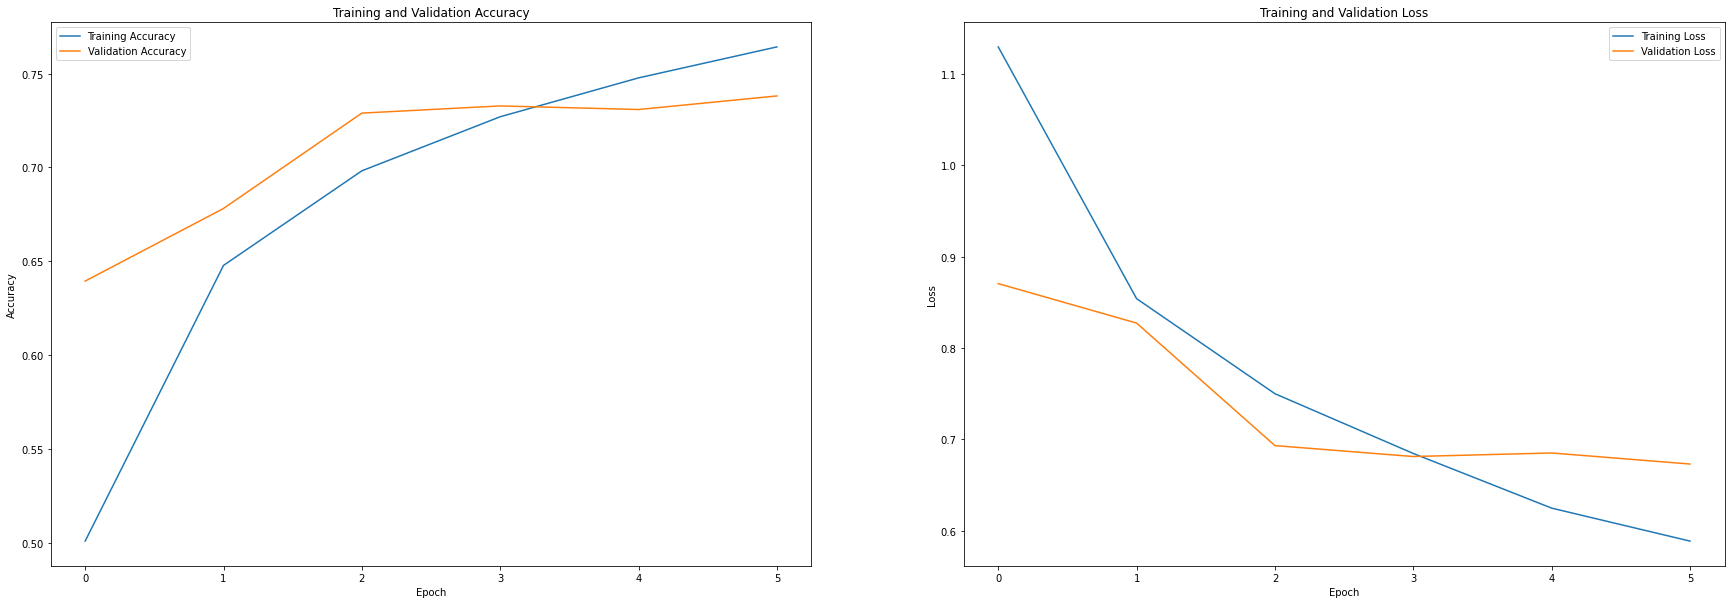

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

In [17]:
_, model_accuracy = model.evaluate(
    test_generator, verbose=0)

print(model_accuracy)

0.7381910681724548


### Predicting the emotion 

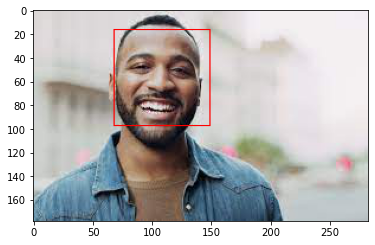

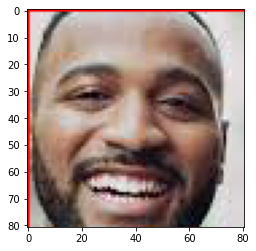

[[0. 1. 0. 0.]]


In [27]:
extracted_face = face_detection('happy.jpg')
extracted_face = np.array(extracted_face)

# Check if any faces are detected
if extracted_face.shape[0] > 0:
    resized = cv2.resize(extracted_face, (48,48), interpolation = cv2.INTER_LANCZOS4)
    img_batch = np.expand_dims(resized, 0)

    # Run the classifier on the detected faces
    y_val_pred = model.predict(img_batch)
    # y_val_pred_1 = np.argmax(y_val_pred, axis=1)
    
    print(y_val_pred)
    # , "/n" ,y_val_pred_1)

else:
    print("Face not detected")


In [37]:
filename = "face01.jpg"
cv2.imwrite(filename, extracted_face)

True

### Saved Model

In [28]:
saved_model_path = 'trained-model/model-recent.h5'
model.save(saved_model_path)

array([[0., 1., 0., 0.]], dtype=float32)

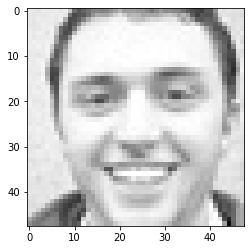

In [36]:
img = cv2.imread('images/validation/happy/30.jpg')
plt.imshow(img)
img = np.expand_dims(img, 0)
model.predict(img)

### Convert to json file